In [213]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter
import pickle

In [214]:
import time, sys
from IPython.display import clear_output

#Progress bar
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [215]:
#Open movie data file
df = pd.read_csv('./../../dataset/credits_short.csv', encoding ='utf-8')
number_of_movies = len(df.index)

In [7]:
def get_actors(movie_cast):
    cast_list = []
    for cast_object in movie_cast:
        cast_list.append(cast_object['name'])
    return cast_list


def list_all_actors():
    l = []
    for i, movie_id in enumerate(df['id'], start = 0):
        try:
            cast = df.loc[df['id']==movie_id]['cast'].item()
            cast_objects = ast.literal_eval(cast)
            list_of_actors = get_actors(cast_objects)
            l = l + list_of_actors
        except:
            pass
    return l

def list_actors_in_multiple_movies():
    l = list_all_actors()
    cnt = Counter(l)
    return ([k for k, v in cnt.items() if v > 1])

def get_director(movie_crew):
    for crew_object in movie_crew:
        if (crew_object['job'] == 'Director'):
            return crew_object['name']

In [8]:
# Create director network where directors are connected if they employed the same actors
# Warning! Takes forever to run!
directors_network = nx.Graph()
directors_errors = []

for i, movie_id in enumerate(df['id'], start = 0):
    update_progress(i / number_of_movies)
    try:
        
        # get cast
        cast = df.loc[df['id']==movie_id]['cast'].item()
        cast_objects = ast.literal_eval(cast)
        list_of_actors = get_actors(cast_objects)
        
        # get director
        crew = df.loc[df['id']==movie_id]['crew'].item()
        crew_object = ast.literal_eval(crew)
        director = get_director(crew_object)
        # add director to network
        if not director in directors_network:
            directors_network.add_node(director)
        # find movies who share at least one actor 
        # we only run the loop though movies that we have not already used, 
        # as these will already be in the graph
        for other_movie in df['id'][i+1:]:
            try:
                cast_other_movie = df.loc[df['id']==other_movie]['cast'].item()
                cast_objects_other_movie = ast.literal_eval(cast_other_movie)
                actors = get_actors(cast_objects_other_movie)
                
                other_crew = df.loc[df['id']==other_movie]['crew'].item()
                other_crew_object = ast.literal_eval(other_crew)
                other_director = get_director(other_crew_object)
                # if there are actors in common
                if (set(list_of_actors) & set(actors) and director != other_director):
                    if not other_director in directors_network:
                        directors_network.add_node(other_director)
                    # if edge exists, then update weight
                    if (directors_network.has_edge(other_director, director)):
                        directors_network[other_director][director]['weight'] += 1
                        directors_network[other_director][director]['movies'].append((movie_id,other_movie, set(list_of_actors) & set(actors)))
                    # otherwise add edge
                    else:
                        directors_network.add_edge(other_director, director, weight=1)
                        directors_network[other_director][director]['movies']=[(movie_id,other_movie, set(list_of_actors) & set(actors))]
            except:
                directors_errors.append(['error in other movie with id: '+ (other_movie)])
    except:
        directors_errors.append(['error in movie with id: '+ str(movie_id)])
update_progress(1)

Progress: [####################] 100.0%


In [212]:
nx.get_edge_attributes(directors_network,'movies')

{('John Lasseter', 'Martin Scorsese'): [(862, 524, {'Don Rickles'})],
 ('John Lasseter', 'Mike Figgis'): [(862, 451, {'Laurie Metcalf'})],
 ('Martin Scorsese', 'Howard Deutch'): [(15602, 524, {'Kevin Pollak'})],
 ('Martin Scorsese',
  'Michael Mann'): [(949, 524, {'Paul Herman', 'Robert De Niro'})],
 ('Martin Scorsese', 'Oliver Stone'): [(10858, 524, {'James Woods'})],
 ('Mike Figgis', 'Mel Brooks'): [(12110, 451, {'Steven Weber'})],
 ('Mike Figgis', 'Allison Anders'): [(5, 451, {'Valeria Golino'})],
 ('Michael Mann', 'Barry Sonnenfeld'): [(949, 8012, {'Martin Ferrero'})],
 ('Michael Mann', 'Jean-Jacques Annaud'): [(949, 78802, {'Val Kilmer'})],
 ('Barry Sonnenfeld', 'Rob Reiner'): [(9087, 8012, {'David Paymer'})],
 ('Barry Sonnenfeld', 'Oliver Stone'): [(10858, 8012, {'David Paymer'})],
 ('Peter Hyams', 'Oliver Stone'): [(9091, 10858, {'Powers Boothe'})],
 ('Oliver Stone', 'Rob Reiner'): [(9087, 10858, {'David Paymer'})],
 ('Oliver Stone', 'Simon Wells'): [(21032, 10858, {'Bob Hoskins

In [9]:
nx.write_gpickle(directors_network,"popular_directors_network.gpickle")

/Users/marita/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


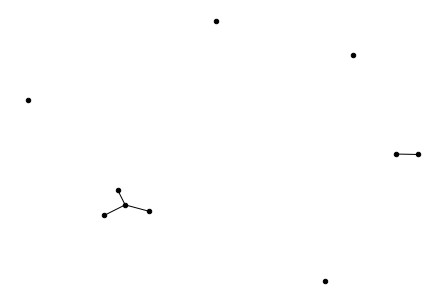

In [26]:
#options = {'node_color': 'black',  
#           'node_size': 20,
#           'width': 1,}
#nx.draw_spring(directors_network, **options)